Code adapted from:
Juho Laitala, Mingzhe Jiang, Elise Syrjälä, Emad Kasaeyan Naeini, Antti
Airola, Amir M. Rahmani, Nikil D. Dutt, and Pasi Liljeberg. 2020. Robust
ECG R-peak Detection Using LSTM. In The 35th ACM/SIGAPP Symposium
on Applied Computing (SAC ’20), March 30-April 3, 2020, Brno, Czech Republic
ACM, New York, NY, USA, Article 4, 8 pages. https://doi.org/10.1145/3341105.
3373945

In [1]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(".."))

# Importing needed libraries
from matplotlib import pyplot as plt
from RNN_files import Laitala_data_original_file
import wfdb
from wfdb.io import get_record_list
from wfdb import rdsamp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from scipy.signal import resample_poly
import xarray as xr
import matplotlib.pyplot as plt
from RNN_files import Laitala_data_original_file
import tensorflow
from tensorflow.keras import layers, models, Input
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

Run this cell and not the one after if using simulated diffraction data.

In [2]:

# path = '/nsls2/users/shasko/Repos/internship_2025/datasets/ds_combined_500_patterns_NaCl.nc'
# ds = xr.open_dataset(path, engine="netcdf4")
# gaussians = ds["Intensities"]
# binary = ds["binary_arr"]
# x = ds["tth"].values

# window_size = 11763

Run this cell and not the previous one if using simulated Gaussian signals. 

In [3]:
path = '/nsls2/users/shasko/Repos/internship_2025/datasets/math_functions_smalldataset.nc' 
ds = xr.open_dataset(path, engine="netcdf4")

gaussians = ds["Gaussians"].values
binary = ds["BinaryArr"].values
print(type(binary))

x = ds["x"].values
window_size = 1000

<class 'numpy.ndarray'>


In [4]:
ds

<xarray.Dataset>
Dimensions:    (pattern: 5000, x: 1000)
Coordinates:
  * pattern    (pattern) int64 0 1 2 3 4 5 6 ... 4994 4995 4996 4997 4998 4999
  * x          (x) float64 0.0 0.01001 0.02002 0.03003 ... 9.97 9.98 9.99 10.0
Data variables:
    Gaussians  (pattern, x) float64 2.174e-17 3.766e-17 ... 2.613e-48 9.194e-49
    BinaryArr  (pattern, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [5]:

tv_gaussians, test_gaussians, tv_binary, test_binary = train_test_split(gaussians, binary, test_size=0.2, shuffle=False)

In [6]:
train_gaussians, val_gaussians, train_binary, val_binary = train_test_split(tv_gaussians, tv_binary, test_size=0.25, shuffle=False)

In [7]:
# gauss_signals_train = [signal for signal in train_gaussians]
# gauss_signals_val = [signal for signal in val_gaussians]
# gauss_signals_test = [signal for signal in test_gaussians]

# binary_labels_train = [label for label in train_binary]
# binary_labels_val = [label for label in val_binary]
# binary_labels_test = [label for label in test_binary]

In [8]:
import wfdb
from wfdb.processing import (
    resample_singlechan,
    find_local_peaks,
    correct_peaks,
    normalize_bound
)

In [9]:
# def data_generator(signals, labels, win_size, batch_size):
   
#     while True:
#         X, y = [], []

#         while len(X) < batch_size:
#             i = np.random.randint(0, len(signals))
#             sig = signals[i]
#             lbl = labels[i]

#             if len(sig) <= win_size + 4:
#                 continue  # skip short signals

#             start = np.random.randint(2, len(sig) - win_size - 2)
#             end = start + win_size

#             data_win = sig[start:end]
#             label_win = lbl[start:end]

#             # Pad 1s ±2 samples around every 1 in label_win
#             padded_label = label_win.copy()
#             ones = np.where(label_win == 1)[0]
#             for p in ones:
#                 for offset in [-2, -1, 1, 2]:
#                     if 0 <= p + offset < win_size:
#                         padded_label[p + offset] = 1

#             # Normalize signal window to (0, 1)
#             # data_win = normalize_bound(data_win, lb=0, ub=1)

#             # Normalized locally
#             data_win = (data_win - np.min(data_win))/(np.max(data_win) - np.min(data_win))

#             # Normalized globally
#             # low = np.min(signals)
#             # high = np.max(signals)
#             # data_win = (data_win - low)/(high - low)

#             X.append(data_win)
#             y.append(padded_label)

#         X = np.array(X).reshape(batch_size, win_size, 1)
#         y = np.array(y).reshape(batch_size, win_size, 1).astype(int)

#         yield X, y

In [10]:
# gen = data_generator(gauss_signals_train, binary_labels_train, win_size=window_size, batch_size=64)
# X_batch, y_batch = next(gen)

In [11]:
# n = next(gen)

In [12]:

# print(type(n))         # likely a tuple
# print(len(n))          # 2: probably (inputs, labels)
# print(n[0].shape)      # input batch shape
# print(n[1].shape)      # label batch shape

# # Plot 4 training examples with labels
# fig, axs = plt.subplots(2, 2)
# fig.set_figheight(10), fig.set_figwidth(18)
# fig.suptitle('Some examples of training data with labels', size=20)

# # first index refers to whether it's an input or label, so noisy signal is input and peaks are labels
# axs[0, 0].plot(n[0][0], color='orange')
# axs[0, 0].plot(n[1][0]+1, color='green')

# axs[0, 1].plot(n[0][1], color='purple')
# axs[0, 1].plot(n[1][1]+1, color='blue')

# axs[1, 0].plot(n[0][2], color='yellow')
# axs[1, 0].plot(n[1][2]+1, color='red')

# axs[1, 1].plot(n[0][3], color='black')
# axs[1, 1].plot(n[1][3]+1, color='grey')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [13]:
n_batch, n_timesteps, n_input_dim = 64, window_size, 1

model = models.Sequential()
model.add(Input(shape=(n_timesteps, n_input_dim)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


In [14]:
model.summary() # view model architecture

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1000, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, 1000, 1)           65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [15]:
checkpoint_path = 'training/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create callback to save model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=2) 

es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                              patience=3,
                                              min_delta=1e-5,
                                              verbose=2)

In [16]:
train_gaussians_reshaped = train_gaussians.reshape(train_gaussians.shape[0], train_gaussians.shape[1], 1)
val_gaussians_reshaped = val_gaussians.reshape(val_gaussians.shape[0], val_gaussians.shape[1], 1)
test_gaussians_reshaped = test_gaussians.reshape(test_gaussians.shape[0], test_gaussians.shape[1], 1)

In [17]:
train_binary_reshaped = train_binary.reshape(train_binary.shape[0], train_binary.shape[1], 1)
val_binary_reshaped = val_binary.reshape(val_binary.shape[0], val_binary.shape[1], 1)
test_binary_reshaped = test_binary.reshape(test_binary.shape[0], test_binary.shape[1], 1)

In [18]:
train_gaussians_sc = train_gaussians_reshaped

In [19]:
train_gaussians_reshaped.shape

(3000, 1000, 1)

In [20]:
train_binary_reshaped.shape

(3000, 1000, 1)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1000, 64)          8704      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 64)          24832     
_________________________________________________________________
dense (Dense)                (None, 1000, 1)           65        
Total params: 33,601
Trainable params: 33,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.fit(x=train_gaussians_reshaped,
          y=train_binary_reshaped,
          batch_size=64,
          epochs=40, 
          validation_data=(val_gaussians_reshaped, val_binary_reshaped),
          callbacks=[cp_callback, es_callback])

Epoch 1/40
47/47 [==============================] - 35s 660ms/step - loss: 0.2041 - acc: 0.9805 - val_loss: 0.0414 - val_acc: 0.9930

Epoch 00001: saving model to training/cp.ckpt
Epoch 2/40
47/47 [==============================] - 30s 635ms/step - loss: 0.0386 - acc: 0.9930 - val_loss: 0.0349 - val_acc: 0.9930

Epoch 00002: saving model to training/cp.ckpt
Epoch 3/40
47/47 [==============================] - 30s 631ms/step - loss: 0.0321 - acc: 0.9930 - val_loss: 0.0296 - val_acc: 0.9930

Epoch 00003: saving model to training/cp.ckpt
Epoch 4/40
47/47 [==============================] - 30s 630ms/step - loss: 0.0274 - acc: 0.9930 - val_loss: 0.0265 - val_acc: 0.9930

Epoch 00004: saving model to training/cp.ckpt
Epoch 5/40
47/47 [==============================] - 30s 633ms/step - loss: 0.0239 - acc: 0.9930 - val_loss: 0.0222 - val_acc: 0.9930

Epoch 00005: saving model to training/cp.ckpt
Epoch 6/40
47/47 [==============================] - 30s 639ms/step - loss: 0.0214 - acc: 0.9930 - va

In [23]:
binary_pred = model.predict(test_gaussians_reshaped,
                            verbose=2)

32/32 - 4s


In [24]:
binary_pred.shape

(1000, 1000, 1)

In [25]:
plt.close('all')

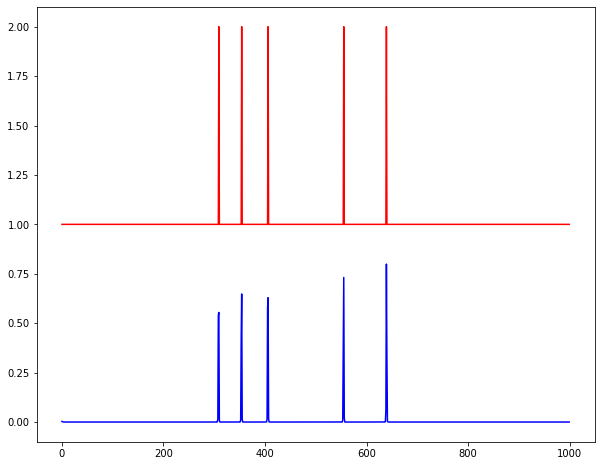

In [43]:
plt.figure(figsize=(10,8))
idx=16
plt.plot(binary_pred[idx], color='blue', label='Pred')
plt.plot(test_binary_reshaped[idx] + 1, color='red', label='True')
plt.show()

In [65]:
# evaluate accuracy
# use f1 score, set prob >= 10% as positive, else negative

binary_pred_adjusted = np.zeros_like(binary_pred)

for j in range(binary_pred.shape[0]):
    idx = np.where(binary_pred[j] >= 0.2)[0]
    binary_pred_adjusted[j][idx] = 1


In [66]:
binary_pred_adjusted.shape

(1000, 1000, 1)

In [67]:
diff = (binary_pred_adjusted - test_binary_reshaped)
print(diff.shape)

all_TP = 0
all_TN = 0
all_FP = 0
all_FN = 0

for i in range(diff.shape[0]):
    true_pos = 0
    true_neg = 0
    fal_pos = 0
    fal_neg = 0
    for j in range(diff.shape[1]):
        if diff[i][j] == 0 and test_binary_reshaped[i][j] == 1: # pred (1) - true (1) = 0
            true_pos += 1
        elif diff[i][j] > 0: # pred (1) - true (0) = 1
            fal_pos += 1
        elif diff[i][j] == 0 and test_binary_reshaped[i][j] == 0: # pred (0) - true (0) = 0
            true_neg += 1
        elif diff[i][j] < 0: # pred (0) - true(1) = -1
            fal_neg += 1
    all_TP += true_pos
    all_TN += true_neg
    all_FP += fal_pos
    all_FN += fal_neg

(1000, 1000, 1)


In [68]:
print(all_TP)
print(all_TN)
print(all_FP)
print(all_FN)

6702
988211
4806
281


In [69]:
prec = all_TP / (all_TP + all_FP)
rec = all_TP / (all_TP + all_FN)

In [70]:
f1 = (2*prec*rec)/(prec+rec)
print(f1)

0.7248931912822455
